# Ice thickness inversion with frontal ablation: a case study

In this notebook we are illustrating how OGGM searches for a frontal calving flux which is compatible with mass conservation, ice thickness estimation based on Glen's flow law, and the calving parameterization of [Oerlemans and Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F).

For more details, see [Recinos et al., (2019)](https://www.the-cryosphere.net/13/2657/2019/tc-13-2657-2019.html).

**History:**
- Feb 2019: this file was created for the [first round of reviews](https://www.the-cryosphere-discuss.net/tc-2018-254/). This original version is still available [here](https://nbviewer.jupyter.org/gist/bearecinos/a0e9c4e80d27b112e9fdb55dd40c4859)
- Jun 2019: the file was moved to a new repository and modified following a new methodology as suggested by the reviewers in the second round of reviews
- April 2020: updated for recent changes in code

## Set-up

These are the usual OGGM workflow commands.

In [1]:
import seaborn as sns
sns.set_context('notebook')

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core.inversion import find_inversion_calving, calving_flux_from_depth

In [24]:
cfg.initialize()
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Calving', reset=True)
cfg.PARAMS['border'] = 10

2021-02-03 13:28:27: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 13:28:27: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 13:28:27: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-03 13:28:27: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


## Pick a glacier 

Here we experiment with Leconte glacier (`RGI60-01.03622`). But you can try with other glaciers as well! See [this list](https://github.com/OGGM/oggm-edu-notebooks/tree/master/data/tidewater_glaciers_wo_processing.csv) for nearly all glaciers simulated in [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/) (we took out the glaciers that need special processing, i.e. because of incorrect outlines like Columbia).

In [26]:
gdir = workflow.init_glacier_directories(['RGI60-01.03622'], from_prepro_level=3)[0]

2021-02-03 13:29:01: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-02-03 13:29:01: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


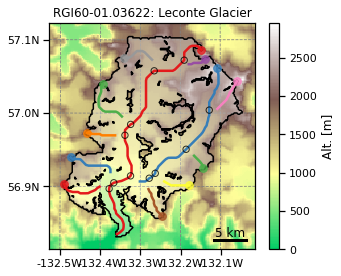

In [27]:
graphics.plot_centerlines(gdir, use_flowlines=True);

**Let's first see the results of the inversion without calving:**

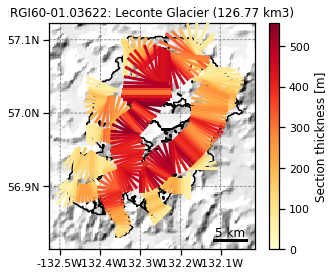

In [7]:
graphics.plot_inversion(gdir);

## The basic principles

We use a simple calving law borrowed from [Oerlemans and Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F), which relates the frontal calving flux $q_{calving}$ to the frontal ice thickness $h_f$, the water depth $d$ and the terminus width $w$

 $$q_{calving} = k h_f d w \; (EQ. \: 1)$$ 

With $q_{calving}$ in km$^3$ yr$^{-1}$, $k$ a calibration parameter (default 2.4 yr$^{-1}$) and $d =$ $h_{f}$ - $E_{t}$ ($E_{t}$ being the free board).

As explained in [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/), ice conservation methods applied to tidewater glaciers *must* take into account this mass-flux at the terminus, otherwise the ice thickness is underestimated. In fact, the default OGGM ice thickness inversion procedure assumes an ice flux of zero at the terminus: 

In [8]:
# Default calving flux:
calving_flux_from_depth(gdir, water_level=0)

{'flux': 0.0016181275571048193,
 'width': 775.0815795377595,
 'thick': 113.78948631464273,
 'inversion_calving_k': 0.6,
 'water_depth': 30.57820241598911,
 'water_level': 0,
 'free_board': 83.21128389865362}

Here, `flux` is the calving flux ($q_{calving}$) in km$^3$ yr$^{-1}$, `free_board` is the height of ice above water ($E_{t}$, i.e. above 0 m a.s.l), `thick` the frontal ice thickness ($h_{f}$) in m (equal to zero per construction in OGGM), `water_depth` the water depth in m (negative here because of the zero ice thickness and a terminus elevation equal to the freeboard imply a positive bedrock elevation), `width` the front width in m.

Now let's see how this calving flux would change if we increase the ice thickness (while keeping the free board fixed, because the surface elevation at the terminus is the only thing we know with "certainty"):

In [9]:
df = []
for thick in np.linspace(0, 500, 51):
    # This function simply computes the calving law
    df.append(calving_flux_from_depth(gdir, thick=thick, water_level=0))
df = pd.DataFrame(df).set_index('thick')

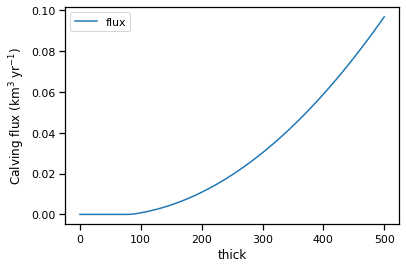

In [10]:
df[['flux']].plot();
plt.ylabel('Calving flux (km$^3$ yr$^{-1}$)');

The flux is zero as long as the ice isn't thick enough to reach the water surface, after which the water depth is positive and calving occurs. The calving flux varies with $H$ as a polynomial of degree 2.

We don't know which is the **real** value of the calving flux at this glacier. From here, let's make some very coarse assumptions:
- the Oerlemans and Nick calving law is perfectly exact
- the tuning parameter $k$ is known
- our glacier is in equilibrium (a fundamental assumption necessary for mass-conservation inversion)
- ice deformation at the glacier terminus follows Glen's flow law

Under these assumptions, we are now going to show, that there are two solutions for the frontal thickness which complies with the calving law and the ice thickness inversion model of OGGM, but only one solution that provides a realistic thickness.

To make our point, we are going to compute a calving flux (from the calving law) for a range of frontal ice thicknesses, then give this flux back to the OGGM inversion model, which will use this flux to compute the frontal ice thickness according to the physics of ice flow (see the [documentation](https://docs.oggm.org/en/latest/inversion.html) or [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/) for more info). Let's see how this works:

In [32]:
# Reference data for the recalibration of the mass-balance
ref_tstars_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/RGIV62/CRU/centerlines/qc3/pcp2.5'
workflow.download_ref_tstars(base_url=ref_tstars_url)

In [12]:
# Ouput dataframe
df = []
# Range of frontal ice thickness from 0 to 500m
for thick in np.linspace(0, 500, 51):
    
    # This function simply computes the flux from the calving law
    out = calving_flux_from_depth(gdir, thick=thick, water_level=0)
    out['thick (prescribed)'] = out.pop('thick')
    
    # Now we feed it back to OGGM
    gdir.inversion_calving_rate = out['flux']
    
    # The mass-balance has to adapt in order to create a flux
    tasks.local_t_star(gdir)    
    tasks.mu_star_calibration(gdir)
    tasks.prepare_for_inversion(gdir)
    v_inv = tasks.mass_conservation_inversion(gdir)
    
    # Now we get the OGGM ice thickness 
    out['thick (oggm)'] = calving_flux_from_depth(gdir, water_level=0)['thick']
    
    # Add sliding (the fs value is outdated, but still)
    v_inv = tasks.mass_conservation_inversion(gdir, fs=5.7e-20)
    out['thick (oggm+sliding)'] = calving_flux_from_depth(gdir, water_level=0)['thick']
    
    # Store
    df.append(out)
    
df = pd.DataFrame(df)

We've got:

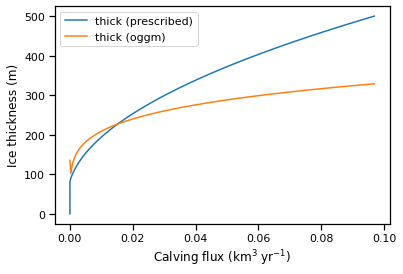

In [13]:
df[['flux', 'thick (prescribed)', 'thick (oggm)']].plot(x='flux');
plt.xlabel('Calving flux (km$^3$ yr$^{-1}$)');
plt.ylabel('Ice thickness (m)');

We already know that the calving law (**EQ. 1**) relates the thickness to the flux with a root of degree two (blue curve). Now, what explains the shape of the orange curve? It is Glen's flow law, which relates ice thickness to the flux with a 5th degree root (assuming n=3). The graphic shows that, for this glacier, there is at least one solution to the problem of finding a calving flux which is compatible with both the calving law and the physics of ice deformation (where the two lines cross).

Note that adding sliding doesn't change the problem (we still solve a polynome of degree 5 in OGGM, [with a new term in degree 3](https://docs.oggm.org/en/latest/ice-dynamics.html)):

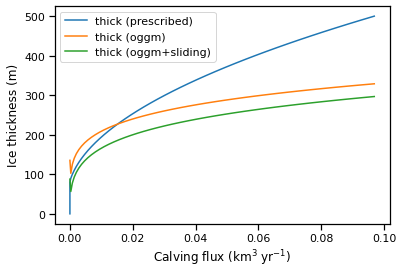

In [14]:
df[['flux', 'thick (prescribed)', 'thick (oggm)', 'thick (oggm+sliding)']].plot(x='flux');
plt.xlabel('Calving flux (km$^3$ yr$^{-1}$)');
plt.ylabel('Ice thickness (m)');   

This plot is a bit misleading. The orange and green curve cross the blue line in two places, as we are going to show.

## Finding the "correct" flux 

What we are looking for are the frontal ice thickness (and corresponding calving flux) that satisfy the following equation: 

$$q_{calving}(h) = q_{OGGM}(h) \; (EQ. \: 2)$$

Where $q_{calving}$ is the flux of ice from the calving law and $q_{OGGM}$ is the [flux of ice due to deformation](https://oggm.readthedocs.io/en/latest/inversion.html). See [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/) for the details on the equations.

In this case, EQ. 2 is a polynomial and could therefore be solved analytically and with [root finding methods](https://docs.scipy.org/doc/numpy/reference/generated/numpy.roots.html). However, we prefer to solve it numerically, for two main reasons:
- finding a numerical solution implied the least change (and copy-paste) in the existing and well-tested code base, therefore minimizing the risk of creating bugs
- numerical solvers are very flexible and can virtually be applied to any other formulation of $q_{calving}$ and $q_{OGGM}$, i.e. the method will still be applicable if we use the lateral drag parameterization in OGGM or use another formulation for the calving law.

Now solve EQ. 2 with a [Bound-Constrained minimization method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). We solve for water depth $d$ (not $h$), because the two are equivalent if the free-board $E_{t}$ is known ($h$ = $d$ + $E_{t}$).

Let's have a look at the function(s) we are seeking roots for:

In [15]:
from oggm.core.inversion import sia_thickness

# Slope and with at the glacier front
cls = gdir.read_pickle('inversion_input')[-1]
slope = cls['slope_angle'][-1]
width = cls['width'][-1]

def to_solve_default(wd):
    # Flux from calving law at given water depth
    fl = calving_flux_from_depth(gdir, water_depth=wd, water_level=0)
    # OGGM thickness obtained from the prescribed flux
    oggm = sia_thickness(slope, width, fl['flux'] * 1e9 / cfg.SEC_IN_YEAR)
    # Difference in thicknesses
    return fl['thick'] - oggm


def to_solve_with_sliding(wd):
    # Flux from calving law at given water depth
    fl = calving_flux_from_depth(gdir, water_depth=wd, water_level=0)
    # OGGM thickness obtained from the prescribed flux
    oggm = sia_thickness(slope, width, fl['flux'] * 1e9 / cfg.SEC_IN_YEAR, fs=5.7e-20)
    # Difference in thicknesses
    return fl['thick'] - oggm

And plot them for a range of possible water depths:

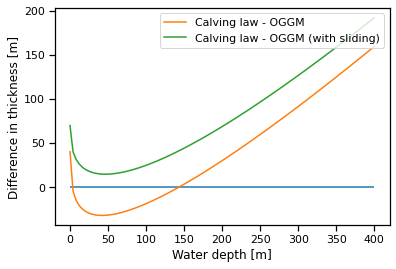

In [16]:
# Ouput dataframe
df = []

# Range of frontal water depth from 0.1 to 400m
for wd in np.linspace(0.1, 400, 100):
    
    out = {
        'Water depth [m]': wd,
        'Calving law - OGGM': to_solve_default(wd),
        'Calving law - OGGM (with sliding)': to_solve_with_sliding(wd),
          }
    
    # Store
    df.append(out)
    
df = pd.DataFrame(df).set_index('Water depth [m]')
df.plot(color=['C1', 'C2']);
plt.hlines([0], 0, 400);
plt.xlabel('Water depth [m]');
plt.ylabel('Difference in thickness [m]');
plt.legend(loc='upper right');

In this representation of the same data as above (here as a function of the prescribed water depth), one sees more clearly that there exists two locations where the zero line is crossed. This pattern is consistent for all but one glaciers in Alaska (see below), and we choose to pick the only realistic solution (the larger of the two). Indeed, the smallest solution leads to unrealistically small water depths and calving fluxes. Note that in the first two versions of the manuscript (with a different way to solve the equations), it is always the largest solution that was found: therefore, there is no noticeable change in the results between the last two manuscript versions.

To solve our problem, we first seek the absolute minimal of the function(s), and then look for zeros above and below this point. It's the larger solution which is retained.

In [17]:
from scipy import optimize
# Absolute minima
abs_min = optimize.minimize(to_solve_default, [1], bounds=((1e-4, 1e4), ))
abs_min['x'][0]

42.14726769695331

Now we find the roots of the functions between the interval  [0.0001 - 10000]. Using the python tool: [optimize.brentq()](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.brentq.html).

As observed in the previous plot we have two minima:

In [18]:
print('Optimum water depth 1 (in m)', optimize.brentq(to_solve_default, 1e-4, abs_min['x'][0]))
print('Optimum water depth 2 (in m)', optimize.brentq(to_solve_default, abs_min['x'][0], 1e4))

Optimum water depth 1 (in m) 2.9899016853556644
Optimum water depth 2 (in m) 143.7924777099962


A frontal ablation flux produced with such small water depth will result in a non realistic thickness at the front.
In the code we always pick the larger solution. 

In [19]:
opt = optimize.brentq(to_solve_default, abs_min['x'][0], 1e4)

Now we give this value to the calving law and calculate a flux:

In [20]:
out = calving_flux_from_depth(gdir, water_depth=opt, water_level=0)
out

{'flux': 0.015179864222832417,
 'width': 775.0815795377595,
 'thick': 227.00376160864982,
 'inversion_calving_k': 0.6,
 'water_depth': 143.7924777099962,
 'water_level': 0,
 'free_board': 83.21128389865362}

The process described above is implemented in the OGGM codebase in the following task: [find_inversion_calving()](https://github.com/OGGM/oggm/blob/b912b1e9952418bf62e45aab98e2fdd96d34c752/oggm/core/inversion.py#L880). This is what we use in operation, and it provides the same results:

In [33]:
cfg.PARAMS['use_kcalving_for_inversion'] = True
out = find_inversion_calving(gdir, water_level=0)
out

2021-02-03 13:31:31: oggm.core.inversion: (RGI60-01.03622) find_inversion_calving
2021-02-03 13:31:34: oggm.core.inversion: (RGI60-01.03622) find_inversion_calving_from_any_mb: found calving flux of 0.015 km3 yr-1


{'calving_flux': 0.015179864222832346,
 'calving_rate_myr': 86.27548662599739,
 'calving_mu_star': 91.70437464471189,
 'calving_law_flux': 0.015179864222832384,
 'calving_water_level': 0,
 'calving_inversion_k': 0.6,
 'calving_front_slope': 0.11600123219190657,
 'calving_front_water_depth': 143.792477709996,
 'calving_front_free_board': 83.21128389865362,
 'calving_front_thick': 227.00376160864963,
 'calving_front_width': 775.0815795377595}

## Testing consistency 

Per definition, the two calving fluxes (OGGM and calving law) are now the same. It is a good consistency check to verify that this is the case:

In [34]:
thick = out['calving_front_thick'] 
df = calving_flux_from_depth(gdir, thick=thick, water_level=0)
np.testing.assert_almost_equal(df['flux'], out['calving_flux']) 
np.testing.assert_almost_equal(gdir.read_pickle('inversion_output')[-1]['thick'][-1], thick)

Same flux!!

## Free board and water level

In the example above, our the glacier has a "free-board" (thickness of the calving front *above* water) of about 85 m. This value is given by the glacier DEM (by construction of the OGGM flowlines, it is the lowest point on the glacier outline). Sometimes, this value can be unrealistically high (> 200 m a.s.l) or low (0 m a.s.l), leading to unrealistic calving values.

Since [this change](https://github.com/OGGM/oggm/pull/996), we are now artificially adapting the water level so that the free-board is within a reasonable range. This range is given by the model parameters:

In [35]:
cfg.PARAMS['free_board_marine_terminating']  # units: m

[10.0, 50.0]

This means that we do not allow free-board higher than 50 (conservative value, could be changed to 75 m). This has an influence on the results. See how the calving flux changes with these new defaults: 

In [36]:
find_inversion_calving(gdir, water_level=None)  # use default values

2021-02-03 13:32:01: oggm.core.inversion: (RGI60-01.03622) find_inversion_calving
2021-02-03 13:32:04: oggm.core.inversion: (RGI60-01.03622) find_inversion_calving_from_any_mb: found calving flux of 0.022 km3 yr-1


{'calving_flux': 0.02220788362949409,
 'calving_rate_myr': 116.97117335284494,
 'calving_mu_star': 91.28106215365878,
 'calving_law_flux': 0.02220788362949414,
 'calving_water_level': 33.21128389865362,
 'calving_inversion_k': 0.6,
 'calving_front_slope': 0.11600123219190657,
 'calving_front_water_depth': 194.95195558807535,
 'calving_front_free_board': 50.0,
 'calving_front_thick': 244.95195558807535,
 'calving_front_width': 775.0815795377595}

In this case, the calving flux slightly increased as a result of an increase in the water depth and the frontal thickness. 

## Mass conservation and the temperature sensitivity $\mu^*$ 

While the computed flux satisfies EQ. 2, we still need to check with the mass balace module if the flux computed above complies with mass conservation. Per construction, OGGM calibrates the mass-balance model so that the flux at the glacier front is zero under equilibrium climate conditions. This is obviously not the case for calving glaciers, and this newly computed flux can be used to better calibrate the model:

In [37]:
# Feed a zero flux to OGGM
gdir.inversion_calving_rate = 0

# Calibrate the mass balance
tasks.local_t_star(gdir)    
tasks.mu_star_calibration(gdir)

# Output
print('mu* for the glacier without calving (in mm w.e. mth-1): '
      '{:.2f}'.format(gdir.read_json('local_mustar')['mu_star_glacierwide']))

# Feed the computed flux now
gdir.inversion_calving_rate = out['calving_flux']

# Calibrate the mass balance
tasks.local_t_star(gdir)    
tasks.mu_star_calibration(gdir)

# Output
print('mu* for the glacier with calving (in mm w.e. mth-1): '
      '{:.2f}'.format(gdir.read_json('local_mustar')['mu_star_glacierwide']))

# Invert for fun
tasks.prepare_for_inversion(gdir)
v_inv = tasks.mass_conservation_inversion(gdir)

2021-02-03 13:32:14: oggm.core.climate: (RGI60-01.03622) local_t_star
2021-02-03 13:32:14: oggm.core.climate: (RGI60-01.03622) local mu* computation for t*=1964
2021-02-03 13:32:14: oggm.core.climate: (RGI60-01.03622) mu_star_calibration
2021-02-03 13:32:15: oggm.core.climate: (RGI60-01.03622) local_t_star
2021-02-03 13:32:15: oggm.core.climate: (RGI60-01.03622) local mu* computation for t*=1964
2021-02-03 13:32:15: oggm.core.climate: (RGI60-01.03622) mu_star_calibration


mu* for the glacier without calving (in mm w.e. mth-1): 92.62


2021-02-03 13:32:16: oggm.core.inversion: (RGI60-01.03622) prepare_for_inversion
2021-02-03 13:32:17: oggm.core.inversion: (RGI60-01.03622) mass_conservation_inversion


mu* for the glacier with calving (in mm w.e. mth-1): 91.70


This is consistent: in order to allow for a frontal ablation flux, melt has to be reduced along the glacier. Note that not only the frontal thickness is affected by this change, the entire glacier becomes thicker:

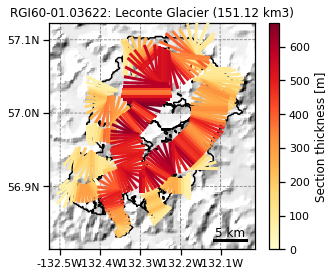

In [38]:
graphics.plot_inversion(gdir);

## Cases where the calving flux isn't consistent with climate 

There is a physical lower bound for $\mu^*$ of zero (which means no melt at all). In this case, all the mass accumulated on the glacier via solid precipitation is transported and lost at the calvong front. In our experiments, this happens when the calving flux is overestimated (likely given all the uncertainties involved in the calving law and the boundary conditions, see [Recinos et al.](https://www.the-cryosphere.net/13/2657/2019/tc-13-2657-2019.html)) or the climate data is biased (also likely). In these cases, we don't accept the solution provided by the calving law but **clip the temperature sensitivity $\mu^*$ to zero**, compute the associated frontal flux, and keep the later as the final solution.

We try a big number for the $k$ parameter to illustrate this event: 

In [41]:
# Will provide a flux too large for OGGM to cope with
cfg.PARAMS['inversion_calving_k'] = 2.4 * 10 
# Change the default clip mechanism to zero
cfg.PARAMS['calving_min_mu_star_frac'] = 0

out = find_inversion_calving(gdir)
out

2021-02-03 13:33:49: oggm.cfg: PARAMS['calving_min_mu_star_frac'] changed from `0.7` to `0`.
2021-02-03 13:33:49: oggm.core.inversion: (RGI60-01.03622) find_inversion_calving
2021-02-03 13:33:51: oggm.core.inversion: (RGI60-01.03622) find_inversion_calving_from_any_mb: found calving flux of 1.538 km3 yr-1


{'calving_flux': 1.5376960627773406,
 'calving_rate_myr': 3470.319893633257,
 'calving_mu_star': 0.0,
 'calving_law_flux': 5.54775220696081,
 'calving_water_level': 33.21128389865362,
 'calving_inversion_k': 24.0,
 'calving_front_slope': 0.11600123219190657,
 'calving_front_water_depth': 521.680760879978,
 'calving_front_free_board': 50.0,
 'calving_front_thick': 571.680760879978,
 'calving_front_width': 775.0815795377595}

After clipping $\mu^*$, we keep the thickness and flux that still statisfy mass-conservation and ice deformation ($q_{OGGM}$) instead of the calving law ($q_{calving}$). 

**New as for version 1.4: we now have a mechanism to clip mu* to a value higher than 0, given as a fraction of the non-calving mu*:**

In [42]:
# Will provide a flux too large for OGGM to cope with
cfg.PARAMS['inversion_calving_k'] = 2.4 * 10 
# Change the default clip mechanism to 70 of non-calving mu*
cfg.PARAMS['calving_min_mu_star_frac'] = 0.7

out = find_inversion_calving(gdir)
out

2021-02-03 13:35:20: oggm.cfg: PARAMS['calving_min_mu_star_frac'] changed from `0` to `0.7`.
2021-02-03 13:35:20: oggm.core.inversion: (RGI60-01.03622) find_inversion_calving
2021-02-03 13:35:22: oggm.core.inversion: (RGI60-01.03622) find_inversion_calving_from_any_mb: found calving flux of 0.930 km3 yr-1


{'calving_flux': 0.930031181321627,
 'calving_rate_myr': 2320.9784896514557,
 'calving_mu_star': 36.600942571485,
 'calving_law_flux': 4.490986124070976,
 'calving_water_level': 33.21128389865362,
 'calving_inversion_k': 24.0,
 'calving_front_slope': 0.11600123219190657,
 'calving_front_water_depth': 466.9862330350195,
 'calving_front_free_board': 50.0,
 'calving_front_thick': 516.9862330350195,
 'calving_front_width': 775.0815795377595}

## Check the robustness of our method

We apply our algorithm to a handful of glaciers and check the solutions. This is not a formal test, see the original paper for regional results:

In [43]:
cfg.initialize(logging_level='CRITICAL')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Calving', reset=True)
cfg.PARAMS['border'] = 10

cfg.PARAMS['inversion_calving_k'] = 2.4  # We put it higher for this example

# Randolmly selected IDs
ids = [
'RGI60-01.04375',
'RGI60-01.03377',
'RGI60-01.01390',
'RGI60-01.14391',
'RGI60-01.20891',
'RGI60-01.10612',
'RGI60-01.17807'
]

for rid in ids:

    gdir = workflow.init_glacier_directories([rid], from_prepro_level=3)[0]

    cls = gdir.read_pickle('inversion_input')[-1]
    slope = cls['slope_angle'][-1]
    width = cls['width'][-1]

    def to_minimize(wd):
        fl = calving_flux_from_depth(gdir, water_depth=wd, water_level=0)
        oggm = sia_thickness(slope, width, np.array([fl['flux'] * 1e9 / cfg.SEC_IN_YEAR]))
        return fl['thick'] - oggm
    
    abs_min = optimize.minimize(to_minimize, [1], bounds=((1e-4, 1e4), ))
    print(rid)
    print('Optimum small (in m)', optimize.brentq(to_minimize, 1e-4, abs_min['x'][0]))
    print('Optimum large (in m)', optimize.brentq(to_minimize, abs_min['x'][0], 1e4))

100% of  64.7 MiB |######################| Elapsed Time: 0:00:04 Time:  0:00:04


RGI60-01.04375
Optimum small (in m) 3.879115018085558
Optimum large (in m) 766.7562471578146
RGI60-01.03377
Optimum small (in m) 0.8767092368563045
Optimum large (in m) 525.2806591959095


100% of  78.4 MiB |######################| Elapsed Time: 0:00:04 Time:  0:00:04


RGI60-01.01390
Optimum small (in m) 0.12725555240651673
Optimum large (in m) 521.2668860494764


100% of  81.9 MiB |######################| Elapsed Time: 0:00:05 Time:  0:00:05


RGI60-01.14391
Optimum small (in m) 0.23994886545730745
Optimum large (in m) 921.3178100109676


100% of  75.3 MiB |######################| Elapsed Time: 0:00:04 Time:  0:00:04


RGI60-01.20891
Optimum small (in m) 0.08746271387787893
Optimum large (in m) 656.9118156598652


100% of  77.2 MiB |######################| Elapsed Time: 0:00:04 Time:  0:00:04


RGI60-01.10612
Optimum small (in m) 2.3932170290279893
Optimum large (in m) 306.7325531822173


100% of  81.7 MiB |######################| Elapsed Time: 0:00:05 Time:  0:00:05


RGI60-01.17807
Optimum small (in m) 7.371858617233926
Optimum large (in m) 130.69421545268608


100% of  78.6 MiB |######################| Elapsed Time: 0:00:04 Time:  0:00:04


The algorithm implemented in OGGM always seeks for the larger solution.

## What about glaciers where no optimal thickness exists?

For 6 glaciers in Alaska, there is no solution which complies with the calving law and ice deformation **with the previous default parameters**. Here for example glacier `RGI60-01.23642` (Tsaa Glacier): 

In [46]:
# Reference data for the recalibration of the mass-balance
ref_tstars_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/RGIV62/CRU/centerlines/qc3/pcp2.5'
workflow.download_ref_tstars(base_url=ref_tstars_url)

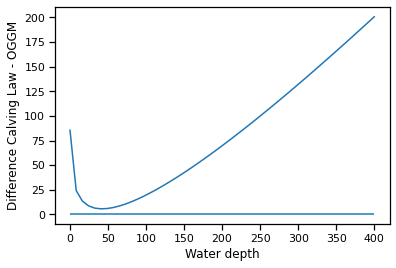

In [44]:
gdir = workflow.init_glacier_directories(['RGI60-01.23642'], from_prepro_level=3)[0]

cls = gdir.read_pickle('inversion_input')[-1]
slope = cls['slope_angle'][-1]
width = cls['width'][-1]

def to_minimize(wd):
    fl = calving_flux_from_depth(gdir, water_depth=wd, water_level=0)
    oggm = sia_thickness(slope, width, np.array([fl['flux'] * 1e9 / cfg.SEC_IN_YEAR]))
    return fl['thick'] - oggm

wd = np.linspace(0.1, 400)
out = []
for w in wd:
    out.append(to_minimize(w)) 
    
plt.plot(wd, out);
plt.hlines([0], 0, 400);
plt.xlabel('Water depth');
plt.ylabel('Difference Calving Law - OGGM');

Put another way, the two laws are simply incompatible. Both curves will never meet in a domain between $q_{calving}$ $>$ 0 and a $q_{calving}$ that results in a non negative $\mu*$. This could be due to several reasons: 
- a difference > 0 between both fluxes in **EQ. 2** corresponds to a glacier state outside of the equilibrium condition under this specific geometry
- the calving law and the ice deformation equation do not represent the physical process affecting this glacier in particulary. Both are parameterised and therefore an approximation of reality
- uncertain boundary conditions

Note that the number of cases where this happens is reduced to only one case when we correct for observed water depths and frontal width, indicating that uncertainties in the boundary conditions are the main problem here.

**With the new defaults, let's see if OGGM can find a suitable solution to this glacier**:

In [51]:
cfg.PARAMS['inversion_calving_k'] = 0.6
cfg.PARAMS['use_kcalving_for_inversion'] = True
out = tasks.find_inversion_calving(gdir)
out

{'calving_flux': 0.028105648810341128,
 'calving_rate_myr': 57.953483737361154,
 'calving_mu_star': 87.9693557855771,
 'calving_law_flux': 0.02810564881034119,
 'calving_water_level': 83.39508240583478,
 'calving_inversion_k': 0.6,
 'calving_front_slope': 0.18201268515440294,
 'calving_front_water_depth': 96.5891395622688,
 'calving_front_free_board': 50.0,
 'calving_front_thick': 146.5891395622688,
 'calving_front_width': 3308.356272260822}

The glacier now calves.

## Discussion

We have shown that under certain assumptions, our method is able to estimate a ice thickness consistent with the calving law and ice deformation. Of course, there are many uncertainties involved, and it is not our attempt to find the "true" calving flux here. See [Recinos et al.](https://www.the-cryosphere.net/13/2657/2019/tc-13-2657-2019.html) for our motivations and a discussion about why it is crucial to include frontal ablation in regional ice thickness estimates.


## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)